In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.pipeline import Pipeline
import category_encoders as ce

import sys
sys.path.insert(1, '../')

from src import preprocessing as pp
from src import analysis

# Enable module reloading
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from sklearn.base import TransformerMixin
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data preprocessing

In this notebook, we are going to preprocess our data, so we can use them during training.

## Load datasets

In [3]:
books = pd.read_csv('../data/books.csv')
reviews = pd.read_csv('../data/reviews.csv')
# intr = pd.read_csv('../data/interactions.csv')
authors = pd.read_csv('../data/authors.csv')

## Merge data

In [4]:
data = pd.merge(books, reviews , on='book_id')

In [5]:
data.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,user_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,NaN,1,['147734'],US,NaN,"[{'count': '1057', 'name': 'to-read'}, {'count...",B0056A00P4,True,4.04,B0056A00P4,"['519546', '1295074', '21407416']",This is the final tale in the bestselling auth...,NaN,https://www.goodreads.com/book/show/12182387-t...,"[{'author_id': '50873', 'role': ''}, {'author_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/12182387-t...,https://s.gr-assets.com/assets/nophoto/book/11...,12182387,4,285263,"The Passion (Dark Visions, #3)","The Passion (Dark Visions, #3)",8a6085f339853bb493a8341f0d7e3bdf,fc61f4a89afd084140b9ea2090e552e2,5,Nachdem Gabriel und Lydia verschwunden sind un...,Fri Sep 09 12:32:42 -0700 2011,Wed Oct 26 11:11:47 -0700 2011,Tue Oct 25 00:00:00 -0700 2011,Sun Oct 23 00:00:00 -0700 2011,0,0
1,NaN,2,['425995'],US,NaN,"[{'count': '1010', 'name': 'to-read'}, {'count...",B006KLYIAG,True,3.80,B006KLYIAG,"['13400912', '13327517', '18107102', '15797097...",Life should be simple for Cassie.\nFor the sma...,NaN,https://www.goodreads.com/book/show/20135365-h...,"[{'author_id': '5395324', 'role': ''}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/20135365-h...,https://s.gr-assets.com/assets/nophoto/book/11...,20135365,5,18450480,Hope's Daughter,Hope's Daughter,c7cafc5c262441aaa9fc8c816dcd20d5,9f5ee0e6211043932bcb46793222c2f6,4,I received this book from the author in exchan...,Wed Apr 04 11:09:28 -0700 2012,Thu Mar 20 11:44:09 -0700 2014,Thu Mar 20 11:44:09 -0700 2014,Wed Mar 19 00:00:00 -0700 2014,2,0
2,0698143760,17,['493993'],US,NaN,"[{'count': '1799', 'name': 'fantasy'}, {'count...",NaN,True,3.80,NaN,"['15728807', '17182499', '15673520', '16081758...",Wanted by no one.\nHunted by everyone.\nSixtee...,ebook,https://www.goodreads.com/book/show/21401181-h...,"[{'author_id': '7314532', 'role': ''}]",Viking Children's,416.0,4.0,9780698143760,3.0,NaN,2014.0,https://www.goodreads.com/book/show/21401181-h...,https://images.gr-assets.com/books/1394747643m...,21401181,33,24802827,"Half Bad (Half Life, #1)","Half Bad (Half Life, #1)",88d99966e16ad22b3d824758e41bdc31,d1c5a076f2433511b239dd4745d88f99,4,Dark story about a young soon to be witch boy....,Fri Mar 24 04:36:25 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Fri Mar 24 04:36:26 -0700 2017,0,0


## Train/Test split

In [6]:
drop_cols = ['rating']

X = data.drop(drop_cols, axis=1)

In [7]:
y = data['rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Create preprocessing pipeline

### books
In this section, we will try to preprocess data from book dataset.

Problems needed to be solved by preprocessing are:
- drop columns that does not contain any useful information for our task (these are also columns that contain most of the missing values)
- replace authors columns with the average rating of authors
- export shelves (by default 'favorites', 'currently-reading', 'to-read', or any other) with number of votes
- normalize and scale the numeric atributes

### Reviews

In this section, we will try to preprocess data from reviews dataset.

Problems needed to be solved by preprocessing are:
- drop columns, that does not contain any usefull information
- since we found out during analysis that longest reviews contain lots of useless data, we will set trashold for max length of review (in number of words)
- get rid of reviews that are not in english
- remove urls from reviews
- remove other special characters
- normalize and scale numeric atributes

In [9]:
X_train.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series', 'user_id', 'review_id', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [108]:
X_train.shape

(1601233, 38)

### Test preprocessing methods

In this section we will test different method of data preprocessing and analyze the effectivity of approaches

In [80]:
def test_preprocessing(df, columns, pipelines, ppl0=None, titles=['1','2','3','4','5'], 
                       kind='box', bins=50):
    dfs = []
    if ppl0 != None:
        dfs.append(ppl0.fit(df).transform(df))
    else:
        dfs = [df]
    for ppl in pipelines:
        dfs.append(ppl.fit(df).transform(df))
        
    fig, axs = plt.subplots(len(columns),len(pipelines) + 1 ,squeeze = False, 
                            figsize = (4 * (len(pipelines) + 1), len(columns) * 4))
    
    for row,col in enumerate(columns):
        for column,df_x in enumerate(dfs):
            ax = axs[row][column] 
            ax.set_title(titles[column])
            if(kind == 'hist'):
                df_x[col].plot(kind=kind, ax=ax, legend=True, bins=bins)
            elif(kind == 'bar'):
                df_x[col].value_counts().plot(kind=kind, ax=ax, legend=True)
            else:
                df_x[col].plot(kind=kind, ax=ax, legend=True)

(fit) ZScoreNormalization
(transform) ZScoreNormalization
(fit) LogNormalization
(transform) LogNormalization
(fit) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(transform) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_s

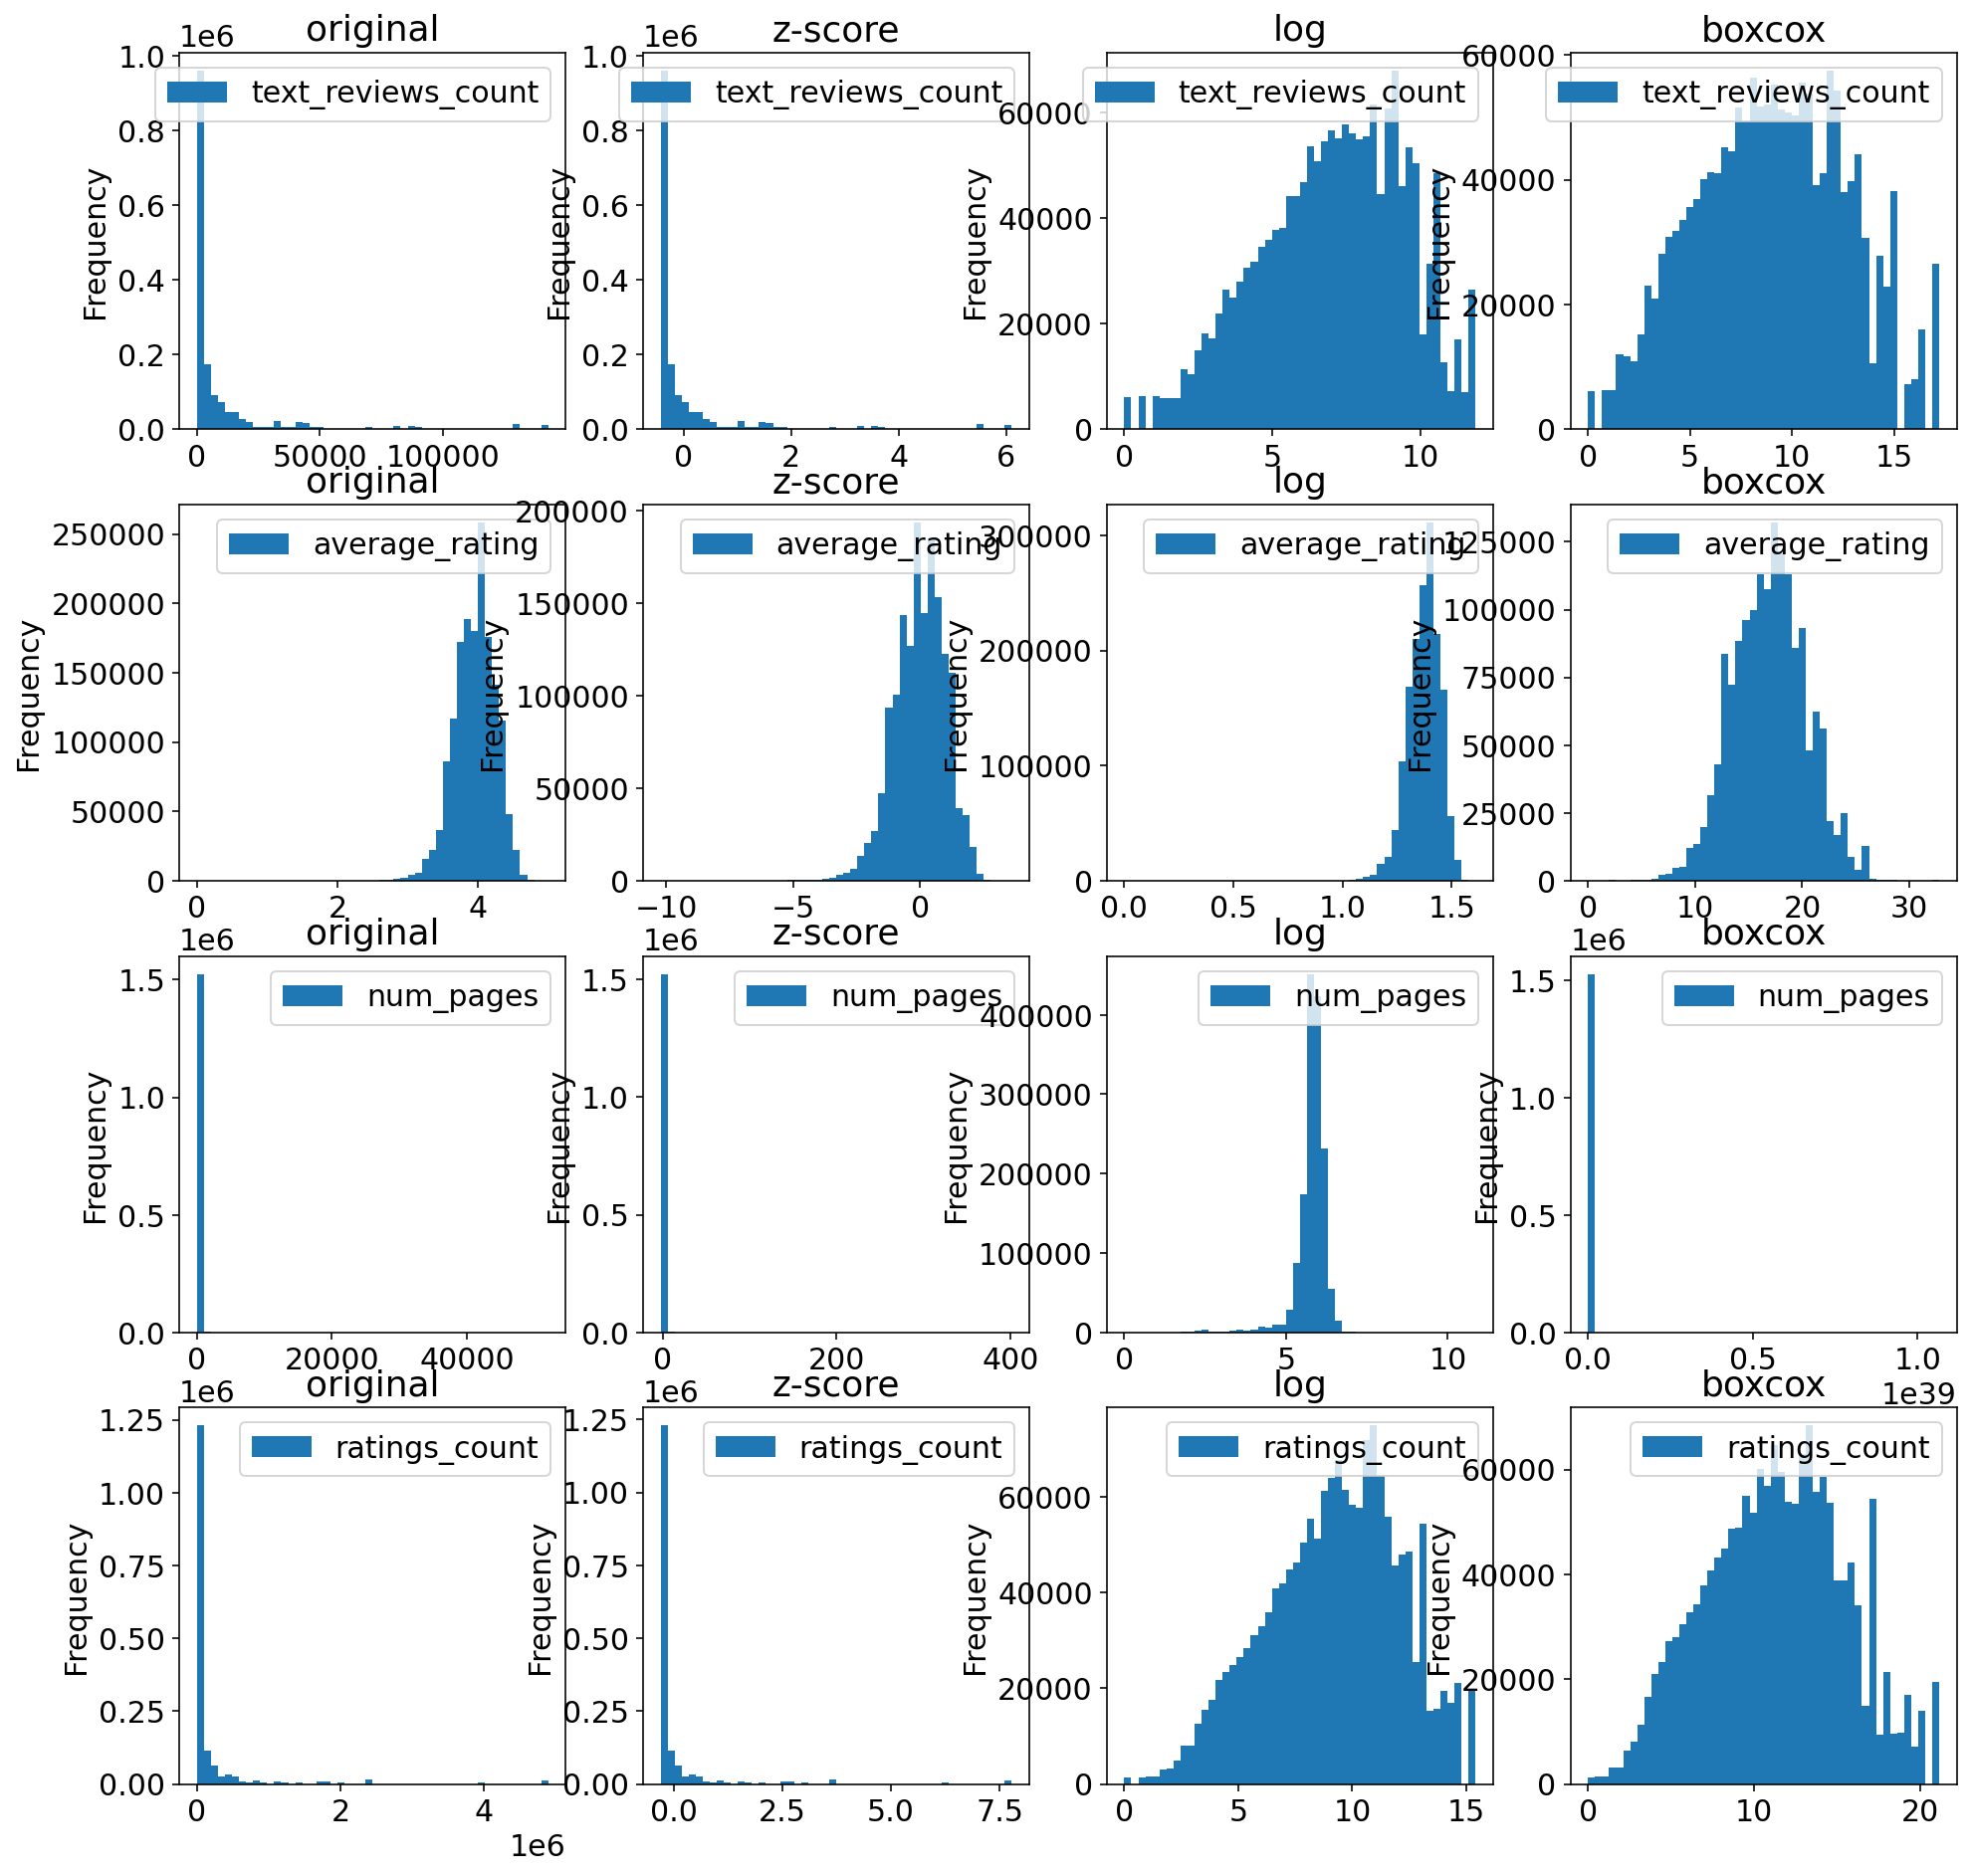

In [107]:
numeric_cols = [
                'text_reviews_count',
                'average_rating',
                'num_pages',
                'ratings_count'
               ]

def drop_zero(df, col_name):
    return [i != 0 for i in df[col_name]] 

ppl1 = Pipeline([
#      ('Scale', pp.Scale(numeric_cols, MinMaxScaler())),
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('ZScore', pp.ZScoreNormalization(numeric_cols))
])
ppl2 = Pipeline([
# #      ('Scale', pp.Scale(numeric_cols, MinMaxScaler())),
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Ln', pp.LogNormalization(numeric_cols))
])
ppl3 = Pipeline([
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Boxcox', pp.BoxCoxNormalization(numeric_cols))
])

titles = ['original', 'z-score', 'log', 'boxcox']


test_preprocessing(X_train, numeric_cols, [ppl1, ppl2, ppl3], titles=titles, kind='hist')

## Final pipeline

In [356]:
drop_cols1 = ['isbn', 'series', 'country_code', 'language_code',
              'asin', 'kindle_asin',
              'description', 
              'format',
              'link',
              'publisher',
              'num_pages',
              'publication_day', 'isbn13', 'publication_month',
              'edition_information',
              'publication_year', 'url', 'image_url',
              'title',
              'title_without_series',
              'date_added', 'date_updated', 'read_at', 'started_at',
              'n_votes',
              'n_comments'
             ]

drop_cols2 = ['popular_shelves', 'authors', 'similar_books']

replace_outliers_cols = ['text_reviews_count']

tags = ['favorites', 'currently-reading', 'to-read']

encoder = ce.OneHotEncoder()

ppl = Pipeline([
    ('DropUnusedCols1', pp.DropColumns(drop_cols1)),
    ('SelectTopNPercentileOfBooks', pp.SelectBooksWithNPercentile('text_reviews_count', 0.9)),
    ('DropOutliers', pp.DropOutliers(replace_outliers_cols)),
#     ('ExportAuthorsAverageRating', pp.ExportAuthorsAverageRating('authors', 'authors_average_rating', authors)),
#     ('ExportSimilarBooksAverageRating', pp.ExportSimilarBooksRating(
#         books[['book_id','average_rating']], 'similar_books', 'sim_books_average_rating')),
#     ('ExtraxtPopularShelves',pp.ExportBookShelves('popular_shelves', tags)),
#     ('EmptyValuesFilter', pp.EmptyValuesFilter(['review_text'])),
#     ('TextPreprocessor', pp.TextPreprocessor('review_text')),
#     ('ReviewLengthFilter', pp.ReviewLengthFilter('review_text', 0, 2000)),
#     ('ReviewsLanguageFilter', pp.ReviewsLanguageFilter('review_text', 'en')),
    ('DropUnusedCols2', pp.DropColumns(drop_cols2)),
#     ('EncodeCategories', pp.EncodeCategories(encoder))
])

model = ppl.fit(X_train.iloc[:5000])

(fit) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(fit) Select books with: text_reviews_count >= 22363.0
(transform) Select books with: text_reviews_count >= 22363.0
-- Drop outliers for:  ['text_reviews_count']
(fit) Drop columns: ['popular_shelves', 'authors', 'similar_books']


In [357]:
pX_train = ppl.transform(X_train.iloc[:5000])

(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Select books with: text_reviews_count >= 22363.0
(transform) Drop columns: ['popular_shelves', 'authors', 'similar_books']


In [358]:
pX_train.head()

,text_reviews_count,is_ebook,average_rating,book_id,ratings_count,work_id,user_id,review_id,review_text
1703631,40116,False,4.21,22628,906322,2236198,ef7adbc97c4a7280882df0f888f1ab92,3c4257add627a71bf658df27348a4866,"If there was a list of banned books, I think t..."
1700061,32909,False,3.69,428263,1146155,2675454,a7958ca78024f0c9a30e5df0bed69560,d5a3b09f72e11ee7c2692738261c9214,My favourite of the series! Now that all the m...
2313973,68482,False,4.23,13335037,1962813,13155899,9e49b762b9c7b6aa8430e9a12ef7fd59,73001ec28d5d5fde69709a6924b7a1f5,I thought this book was decent but some things...
612566,31536,False,4.43,11387515,255461,16319487,9babe654bdebdcd89f4044e4202c8260,5b4cb7933029d4313b3648f521a07a76,I don't think words can describe the experienc...
616703,31536,False,4.43,11387515,255461,16319487,17011978371273cb19718587a0c81933,968ec59fc0778d42108c3c0c6e1a4289,I finsished this book a long time ago. I like ...
